# Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb

#!pip install pyarrow

/Users/andrealopez/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Import Data

In [2]:
df = pd.read_parquet('met_gas_site.snappy.parquet')

In [3]:
df.dtypes

SITE_ID                          object
DATE_TIME                datetime64[ns]
TEMPERATURE                      object
TEMPERATURE_F                    object
TEMPERATURE_DELTA                object
TEMPERATURE_DELTA_F              object
RELATIVE_HUMIDITY                object
RELATIVE_HUMIDITY_F              object
SOLAR_RADIATION                  object
SOLAR_RADIATION_F                object
OZONE                            object
OZONE_F                          object
PRECIPITATION                    object
PRECIPITATION_F                  object
WINDSPEED                        object
WINDSPEED_F                      object
WIND_DIRECTION                   object
WIND_DIRECTION_F                 object
SIGMA_THETA                      object
SIGMA_THETA_F                    object
FLOW_RATE                        object
FLOW_RATE_F                      object
WINDSPEED_SCALAR                 object
WINDSPEED_SCALAR_F               object
WETNESS                          object


In [4]:
df.shape

(574851, 51)

In [ ]:
# df_hg = pd.read_parquet('data/hourly_gas_combined.snappy.parquet', engine='pyarrow')
# df_md = pd.read_parquet('data/metdata_combined.snappy.parquet', engine='pyarrow')
# df_md_col_info = pd.read_csv('data/metdata_2023_columninfo.csv')

# Data Cleaning

In [5]:
percent_na = df.isna().sum() / len(df)
percent_na

SITE_ID                  0.000000
DATE_TIME                0.000000
TEMPERATURE              0.000478
TEMPERATURE_F            0.977178
TEMPERATURE_DELTA        0.804843
TEMPERATURE_DELTA_F      0.186956
RELATIVE_HUMIDITY        0.381334
RELATIVE_HUMIDITY_F      0.609808
SOLAR_RADIATION          0.391444
SOLAR_RADIATION_F        0.586538
OZONE                    0.000000
OZONE_F                  0.962691
PRECIPITATION            0.390978
PRECIPITATION_F          0.596588
WINDSPEED                0.379180
WINDSPEED_F              0.593752
WIND_DIRECTION           0.379300
WIND_DIRECTION_F         0.593613
SIGMA_THETA              0.379180
SIGMA_THETA_F            0.594161
FLOW_RATE                0.065090
FLOW_RATE_F              0.924450
WINDSPEED_SCALAR         0.379187
WINDSPEED_SCALAR_F       0.613825
WETNESS                  0.800357
WETNESS_F                0.195426
SHELTER_TEMPERATURE      0.000929
SHELTER_TEMPERATURE_F    0.995498
QA_CODE                  0.000000
UPDATE_DATE   

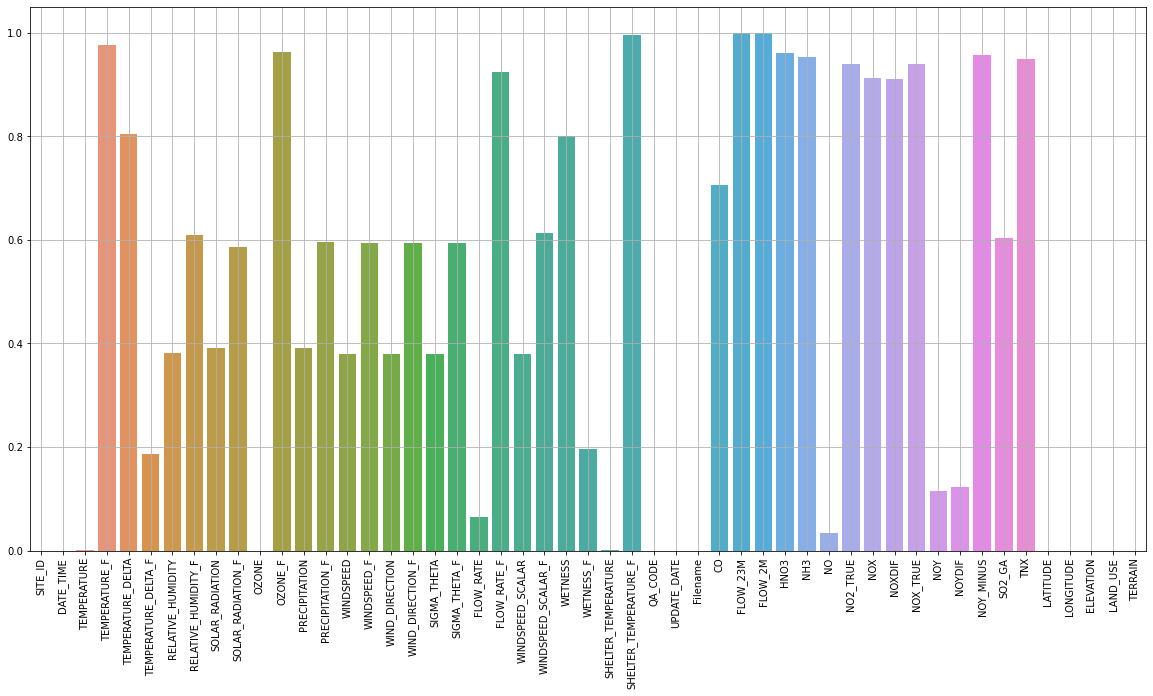

In [6]:
plt.figure(figsize=(20, 10))
sns.barplot(x=percent_na.index.tolist(), y=percent_na.tolist())
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

In [7]:
df.drop(columns=['FLOW_23M', 'FLOW_2M'], axis=1, inplace=True)

**Add month and year features**

In [8]:
df['DATE_TIME']
df['month'] = df['DATE_TIME'].dt.month
df['year'] = df['DATE_TIME'].dt.year

**Convert dtypes**

In [9]:
numerical_columns = ['TEMPERATURE', 'TEMPERATURE_DELTA', 'RELATIVE_HUMIDITY',
                    'SOLAR_RADIATION', 'OZONE', 'PRECIPITATION', 'WINDSPEED',
                     'WIND_DIRECTION', 'SIGMA_THETA', 'FLOW_RATE', 'WINDSPEED_SCALAR',
                    'WETNESS', 'SHELTER_TEMPERATURE', 'CO', 'HNO3', 'NH3', 'NO',
                     'NO2_TRUE', 'NOX', 'NOXDIF', 'NOX_TRUE', 'NOY','NOYDIF', 'NOY_MINUS',
                     'SO2_GA', 'TNX', 'LATITUDE', 'LONGITUDE', 'ELEVATION']
for col in numerical_columns:
    df[col] = df[col].astype(float)

df.dtypes

SITE_ID                          object
DATE_TIME                datetime64[ns]
TEMPERATURE                     float64
TEMPERATURE_F                    object
TEMPERATURE_DELTA               float64
TEMPERATURE_DELTA_F              object
RELATIVE_HUMIDITY               float64
RELATIVE_HUMIDITY_F              object
SOLAR_RADIATION                 float64
SOLAR_RADIATION_F                object
OZONE                           float64
OZONE_F                          object
PRECIPITATION                   float64
PRECIPITATION_F                  object
WINDSPEED                       float64
WINDSPEED_F                      object
WIND_DIRECTION                  float64
WIND_DIRECTION_F                 object
SIGMA_THETA                     float64
SIGMA_THETA_F                    object
FLOW_RATE                       float64
FLOW_RATE_F                      object
WINDSPEED_SCALAR                float64
WINDSPEED_SCALAR_F               object
WETNESS                         float64


**Encode categorical variables**

In [10]:
categorical_columns = ['LAND_USE', 'TERRAIN']

for feature in categorical_columns:
    encoder = OneHotEncoder()
    encoded_data = encoder.fit_transform(df[[feature]])
    df[encoder.categories_[0]] = encoded_data.toarray()

df.drop(columns=categorical_columns, axis=1, inplace=True)

**Remove remaining non-numerical variables**

In [11]:
flag_columns = ['TEMPERATURE_F','TEMPERATURE_DELTA_F', 
       'RELATIVE_HUMIDITY_F', 'SOLAR_RADIATION_F', 
       'OZONE_F', 'PRECIPITATION_F',
       'WINDSPEED_F', 'WIND_DIRECTION_F', 
       'SIGMA_THETA_F', 'FLOW_RATE_F', 
       'WINDSPEED_SCALAR_F', 'WETNESS_F',
       'SHELTER_TEMPERATURE_F', 'QA_CODE']

# Remove flags and other unnecessary categorical and dates
df = df.drop(columns=flag_columns)
df = df.drop(columns=['SITE_ID', 'DATE_TIME', 'UPDATE_DATE', 'Filename'])
df.dtypes

TEMPERATURE            float64
TEMPERATURE_DELTA      float64
RELATIVE_HUMIDITY      float64
SOLAR_RADIATION        float64
OZONE                  float64
PRECIPITATION          float64
WINDSPEED              float64
WIND_DIRECTION         float64
SIGMA_THETA            float64
FLOW_RATE              float64
WINDSPEED_SCALAR       float64
WETNESS                float64
SHELTER_TEMPERATURE    float64
CO                     float64
HNO3                   float64
NH3                    float64
NO                     float64
NO2_TRUE               float64
NOX                    float64
NOXDIF                 float64
NOX_TRUE               float64
NOY                    float64
NOYDIF                 float64
NOY_MINUS              float64
SO2_GA                 float64
TNX                    float64
LATITUDE               float64
LONGITUDE              float64
ELEVATION              float64
month                    int32
year                     int32
Agric                  float64
Desert  

**DROP NA**

In [13]:
df.isna().sum() / len(df)

TEMPERATURE            0.000478
TEMPERATURE_DELTA      0.804843
RELATIVE_HUMIDITY      0.381334
SOLAR_RADIATION        0.391444
OZONE                  0.000000
PRECIPITATION          0.390978
WINDSPEED              0.379180
WIND_DIRECTION         0.379300
SIGMA_THETA            0.379180
FLOW_RATE              0.065090
WINDSPEED_SCALAR       0.379187
WETNESS                0.800357
SHELTER_TEMPERATURE    0.000929
CO                     0.706778
HNO3                   0.960452
NH3                    0.952638
NO                     0.034746
NO2_TRUE               0.940498
NOX                    0.913637
NOXDIF                 0.910121
NOX_TRUE               0.940341
NOY                    0.114318
NOYDIF                 0.122244
NOY_MINUS              0.957940
SO2_GA                 0.604252
TNX                    0.948917
LATITUDE               0.000000
LONGITUDE              0.000000
ELEVATION              0.000000
month                  0.000000
year                   0.000000
Agric   

In [14]:
df.dropna()

,TEMPERATURE,TEMPERATURE_DELTA,RELATIVE_HUMIDITY,SOLAR_RADIATION,OZONE,PRECIPITATION,WINDSPEED,WIND_DIRECTION,SIGMA_THETA,FLOW_RATE,...,month,year,Agric,Desert,Forest,Range,Complex,Flat,Mountaintop,Rolling


In [15]:
X = df.drop(columns=['HNO3', 'NH3', 'NO2_TRUE', 'NOX', 'NOXDIF', 'NOX_TRUE',
                               'NOY_MINUS', 'SO2_GA', 'TNX'])
X.dropna(inplace=True)
X # 43,720 rows

,TEMPERATURE,TEMPERATURE_DELTA,RELATIVE_HUMIDITY,SOLAR_RADIATION,OZONE,PRECIPITATION,WINDSPEED,WIND_DIRECTION,SIGMA_THETA,FLOW_RATE,...,month,year,Agric,Desert,Forest,Range,Complex,Flat,Mountaintop,Rolling
4908,-7.392,-0.631,70.59,406.300,25.72,0.000,4.911,352.70,9.200,1.505,...,1,2013,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4909,-6.679,-0.640,66.38,469.900,28.73,0.000,5.848,351.20,7.959,1.505,...,1,2013,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4910,-10.660,1.982,78.98,0.368,22.77,0.000,2.971,297.40,4.853,1.505,...,1,2013,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4911,-11.610,1.282,80.50,0.392,20.36,0.000,2.803,321.40,5.497,1.505,...,1,2013,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4912,-14.450,1.894,86.20,0.387,15.42,0.000,0.756,243.70,8.310,1.505,...,1,2013,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567844,18.380,-0.401,28.68,506.700,41.96,0.000,8.140,297.90,10.230,1.512,...,9,2022,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
567846,16.140,-0.511,45.63,274.500,29.20,0.000,2.404,13.49,18.140,1.512,...,9,2022,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
567847,8.180,-0.395,80.70,292.700,14.04,0.000,2.434,68.93,9.240,1.512,...,9,2022,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
567848,15.960,-0.953,55.09,706.800,32.03,0.000,3.942,44.43,18.790,1.512,...,9,2022,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# Data Visualization

### Visualize Numerical Variables

count    43720.000000
mean         4.502817
std          2.650055
min          0.000000
25%          2.544000
50%          3.990000
75%          6.070000
max         20.250000
Name: WINDSPEED, dtype: float64
Number of windspeeds < 0: 0


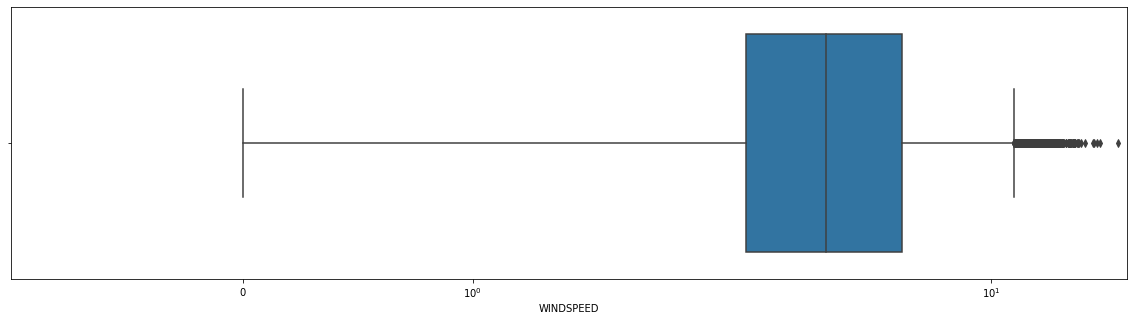

In [16]:
windspeed = X['WINDSPEED']
print(windspeed.describe())
print('Number of windspeeds < 0: ' + str((windspeed < 0).sum()))
plt.figure(figsize=(20, 5))
sns.boxplot(x=windspeed)
plt.xscale('symlog')
plt.show()

count    574576.000000
mean          9.459326
std          14.347604
min        -250.300000
25%           1.500000
50%          10.550000
75%          18.500000
max         202.600000
Name: TEMPERATURE, dtype: float64


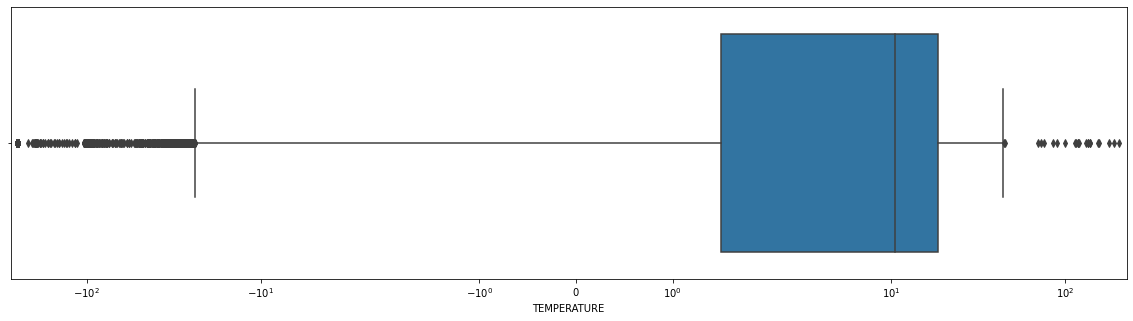

In [17]:
temperature = df['TEMPERATURE']
print(temperature.describe())
plt.figure(figsize=(20, 5))
sns.boxplot(x=temperature)
plt.xscale('symlog')
plt.show()

count    574851.000000
mean         36.275716
std          13.186266
min           0.000000
25%          27.370000
50%          37.190000
75%          45.940000
max         107.500000
Name: OZONE, dtype: float64


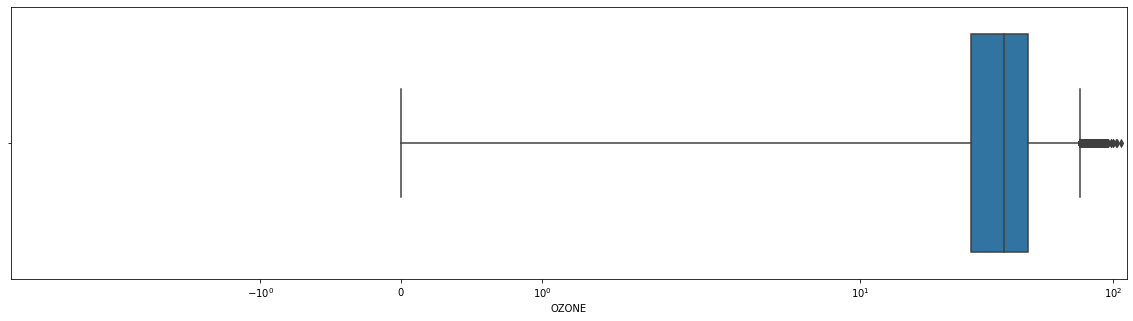

In [18]:
ozone = df['OZONE']
print(ozone.describe())
plt.figure(figsize=(20, 5))
sns.boxplot(x=ozone)
plt.xscale('symlog')
plt.savefig('ozone_boxplot.png', dpi=300)
plt.show()

count    355641.000000
mean         64.954050
std          23.886139
min         -49.000000
25%          47.320000
50%          68.000000
75%          85.000000
max         110.000000
Name: RELATIVE_HUMIDITY, dtype: float64


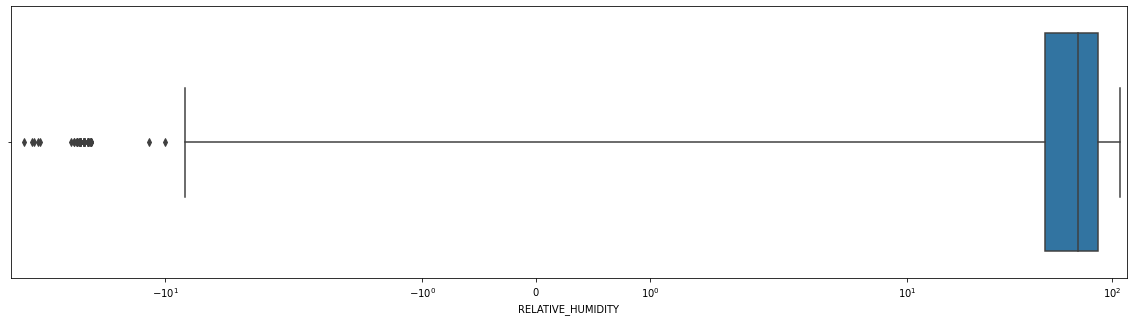

In [19]:
rel_humid = df['RELATIVE_HUMIDITY']
print(rel_humid.describe())
plt.figure(figsize=(20, 5))
sns.boxplot(x=rel_humid)
plt.xscale('symlog')
plt.show()

count    350097.000000
mean          1.170284
std         177.682915
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       54864.000000
Name: PRECIPITATION, dtype: float64


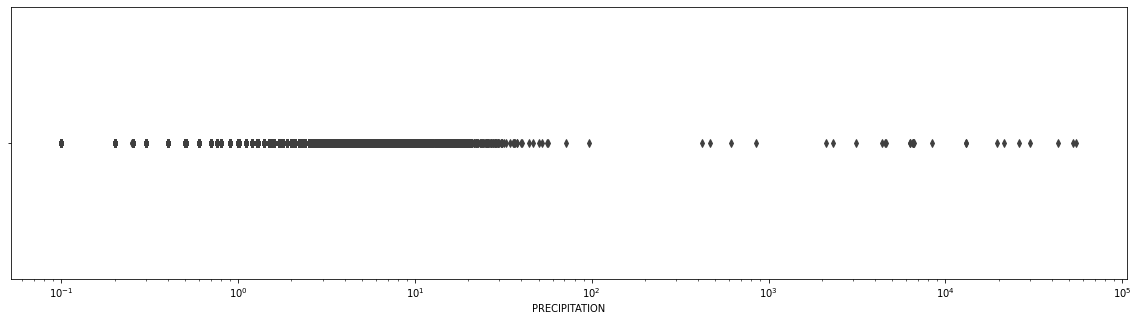

In [20]:
precipitation = df['PRECIPITATION']
print(precipitation.describe())
plt.figure(figsize=(20, 5))
sns.boxplot(x=precipitation)
plt.xscale('log')
plt.show()

count    114765.000000
mean          0.243042
std           0.412803
min          -0.216000
25%           0.000000
50%           0.000000
75%           0.400000
max           1.017000
Name: WETNESS, dtype: float64


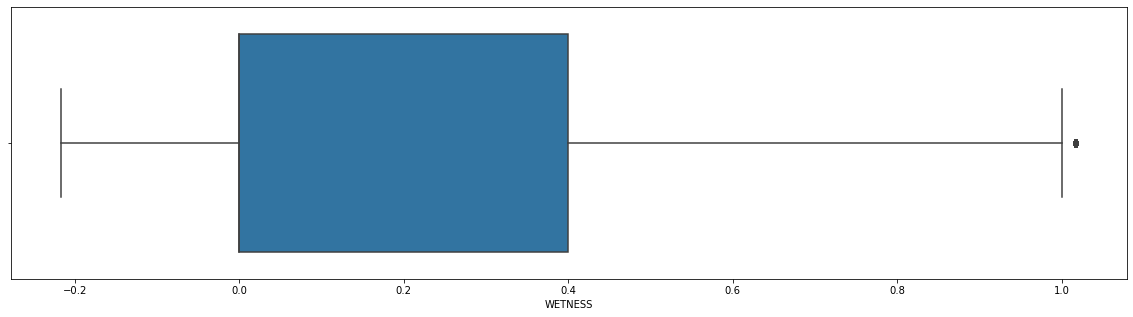

In [21]:
wetness = df['WETNESS']
print(wetness.describe())
plt.figure(figsize=(20, 5))
sns.boxplot(x=wetness)
plt.show()

count    349829.000000
mean        182.200943
std         268.047203
min        -575.000000
25%           0.000000
50%          13.000000
75%         312.000000
max        1574.000000
Name: SOLAR_RADIATION, dtype: float64


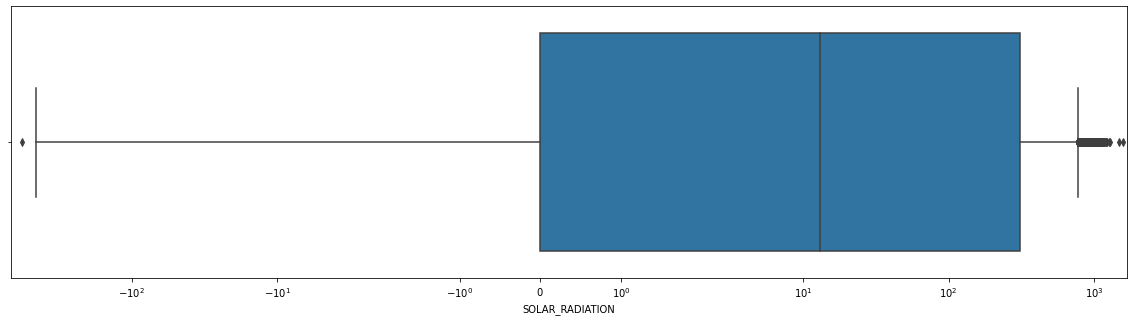

In [22]:
solar = df['SOLAR_RADIATION']
print(solar.describe())
plt.figure(figsize=(20, 5))
sns.boxplot(x=solar)
plt.xscale('symlog')
plt.show()

### Visualize Categorical Variables

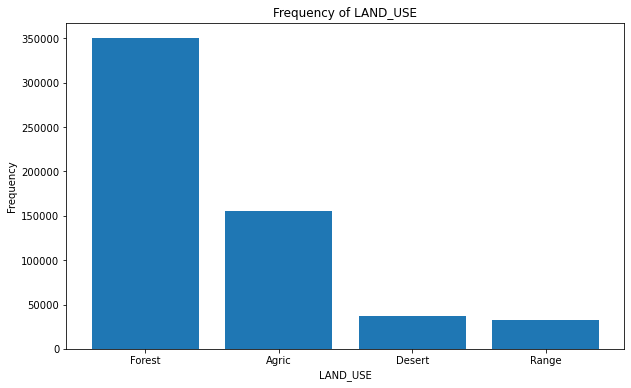

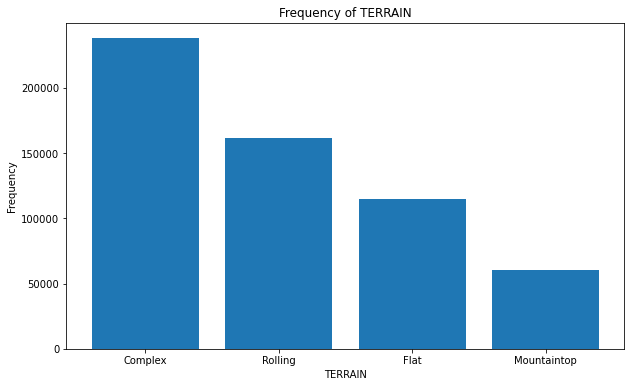

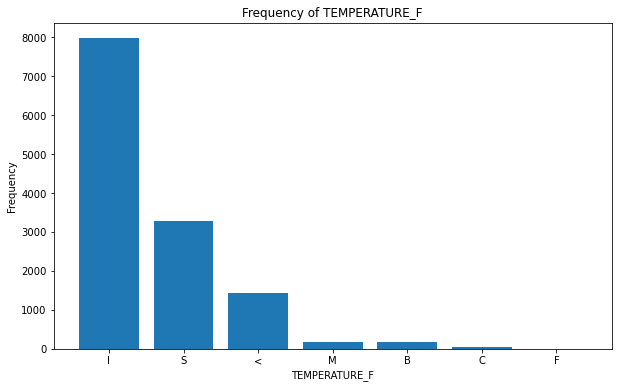

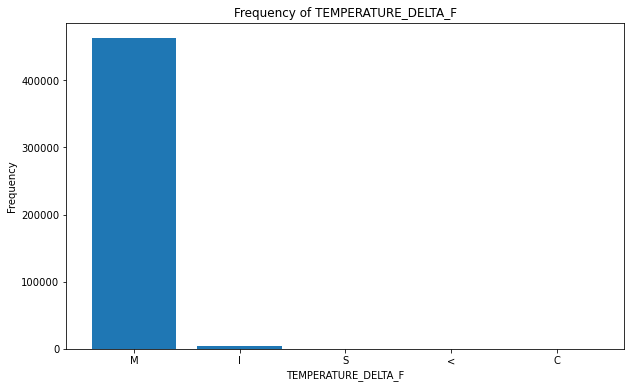

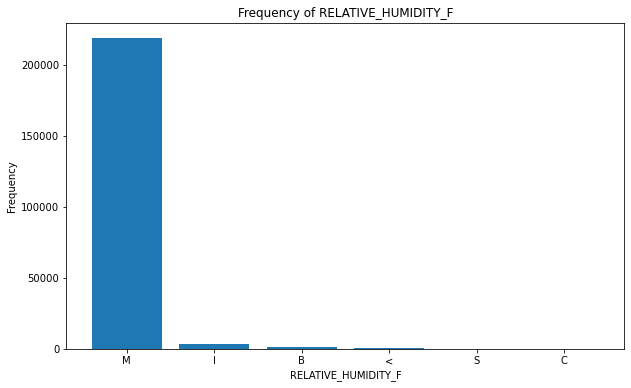

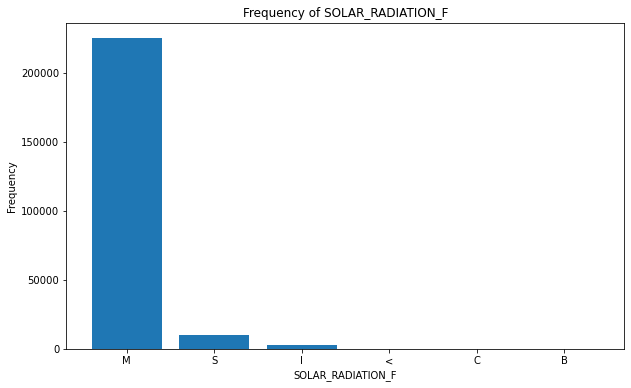

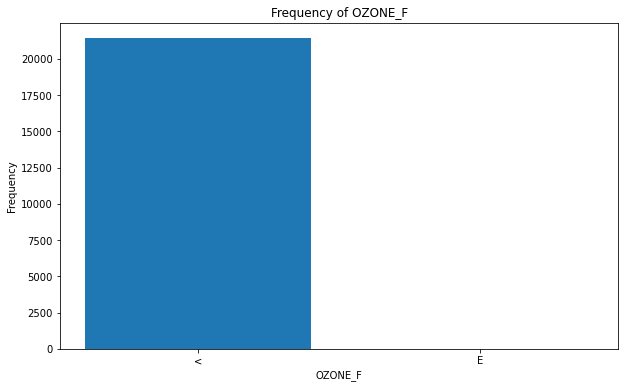

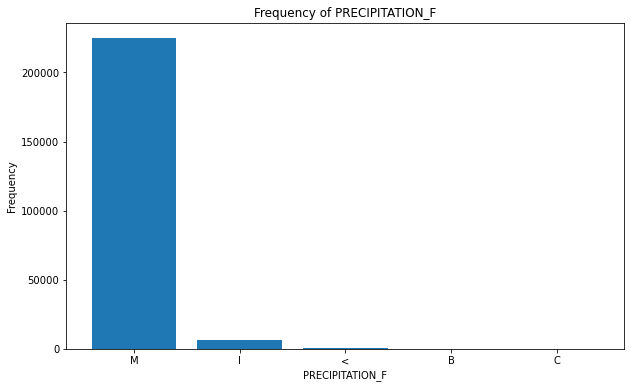

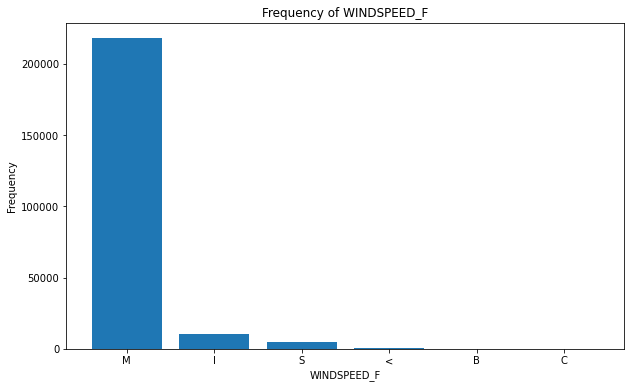

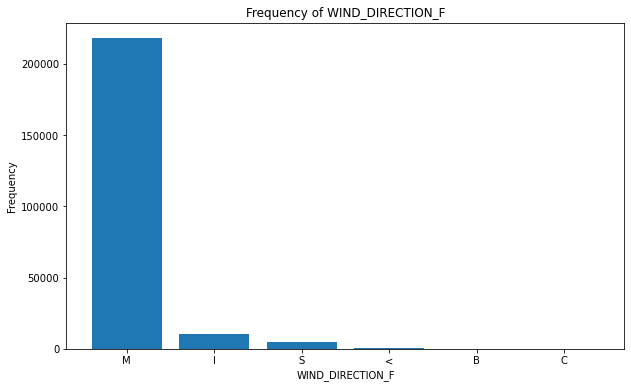

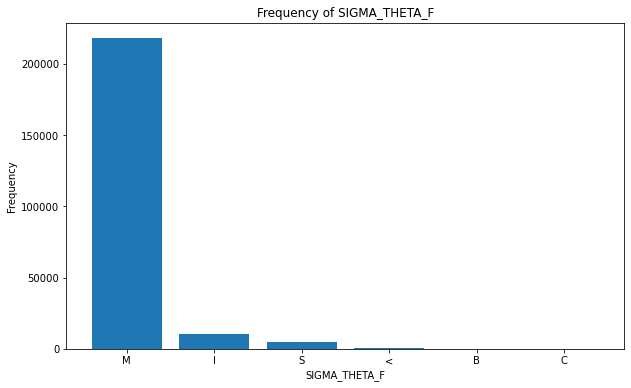

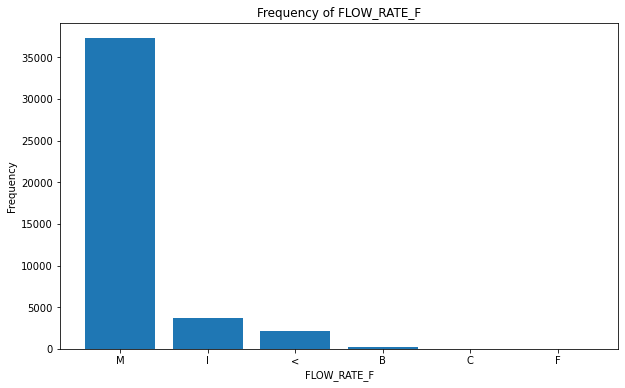

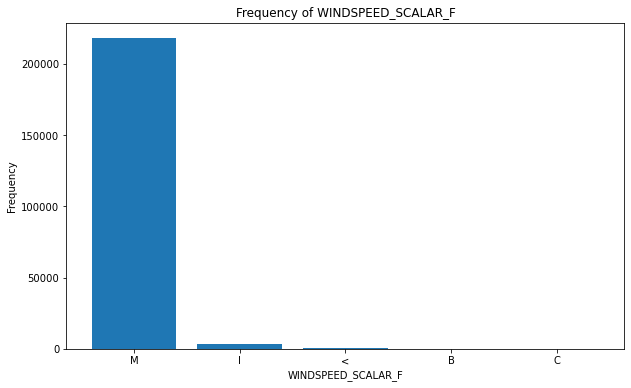

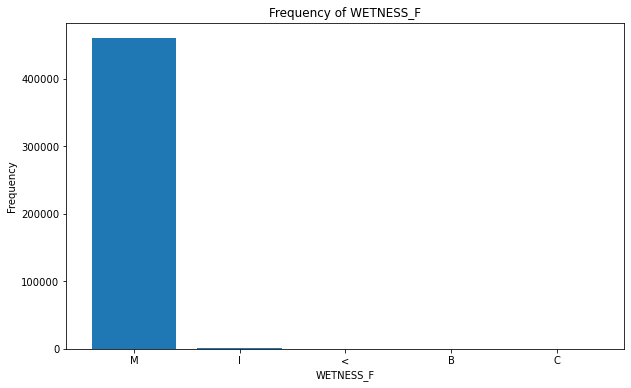

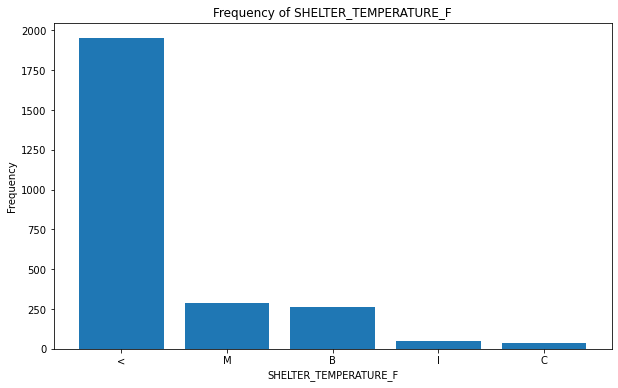

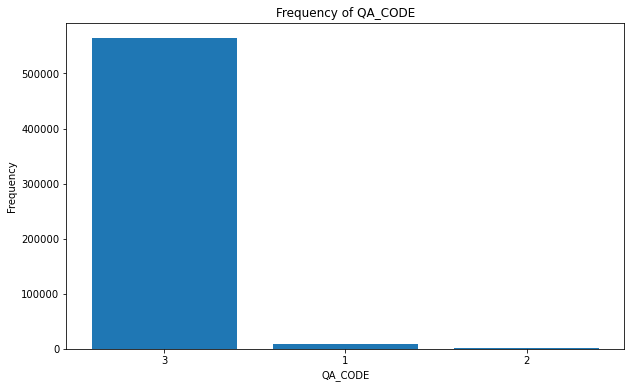

CPU times: user 1.99 s, sys: 246 ms, total: 2.24 s
Wall time: 2.24 s


In [31]:
%%time

#df_cat = pd.read_parquet('met_gas_site.snappy.parquet')
# df_cat = df_cat.drop(columns=['HNO3', 'NH3', 'NO2_TRUE', 'NOX', 'NOXDIF', 'NOX_TRUE',
#                                'NOY_MINUS', 'SO2_GA', 'TNX'])

cat_columns = ['LAND_USE', 'TERRAIN'] + flag_columns

for column in cat_columns:
    value_counts = df_cat[column].value_counts()
    
    plt.figure(figsize=(10, 6))
    plt.bar(value_counts.index, value_counts.values)
    
    plt.title(f'Frequency of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
        
    plt.show()


### Visualize Correlation

In [33]:
X.columns

Index(['TEMPERATURE', 'TEMPERATURE_DELTA', 'RELATIVE_HUMIDITY',
       'SOLAR_RADIATION', 'OZONE', 'PRECIPITATION', 'WINDSPEED',
       'WIND_DIRECTION', 'SIGMA_THETA', 'FLOW_RATE', 'WINDSPEED_SCALAR',
       'WETNESS', 'SHELTER_TEMPERATURE', 'CO', 'NO', 'NOY', 'NOYDIF',
       'LATITUDE', 'LONGITUDE', 'ELEVATION', 'month', 'year', 'Agric',
       'Desert', 'Forest', 'Range', 'Complex', 'Flat', 'Mountaintop',
       'Rolling'],
      dtype='object')

In [ ]:
%%time
sns.pairplot(X.drop(columns=['LATITUDE', 'LONGITUDE', 'month', 'year', 'Agric', 'Desert', 'Forest',
                            'Range', 'Complex', 'Flat', 'Mountaintop', 'Rolling']))
plt.show()

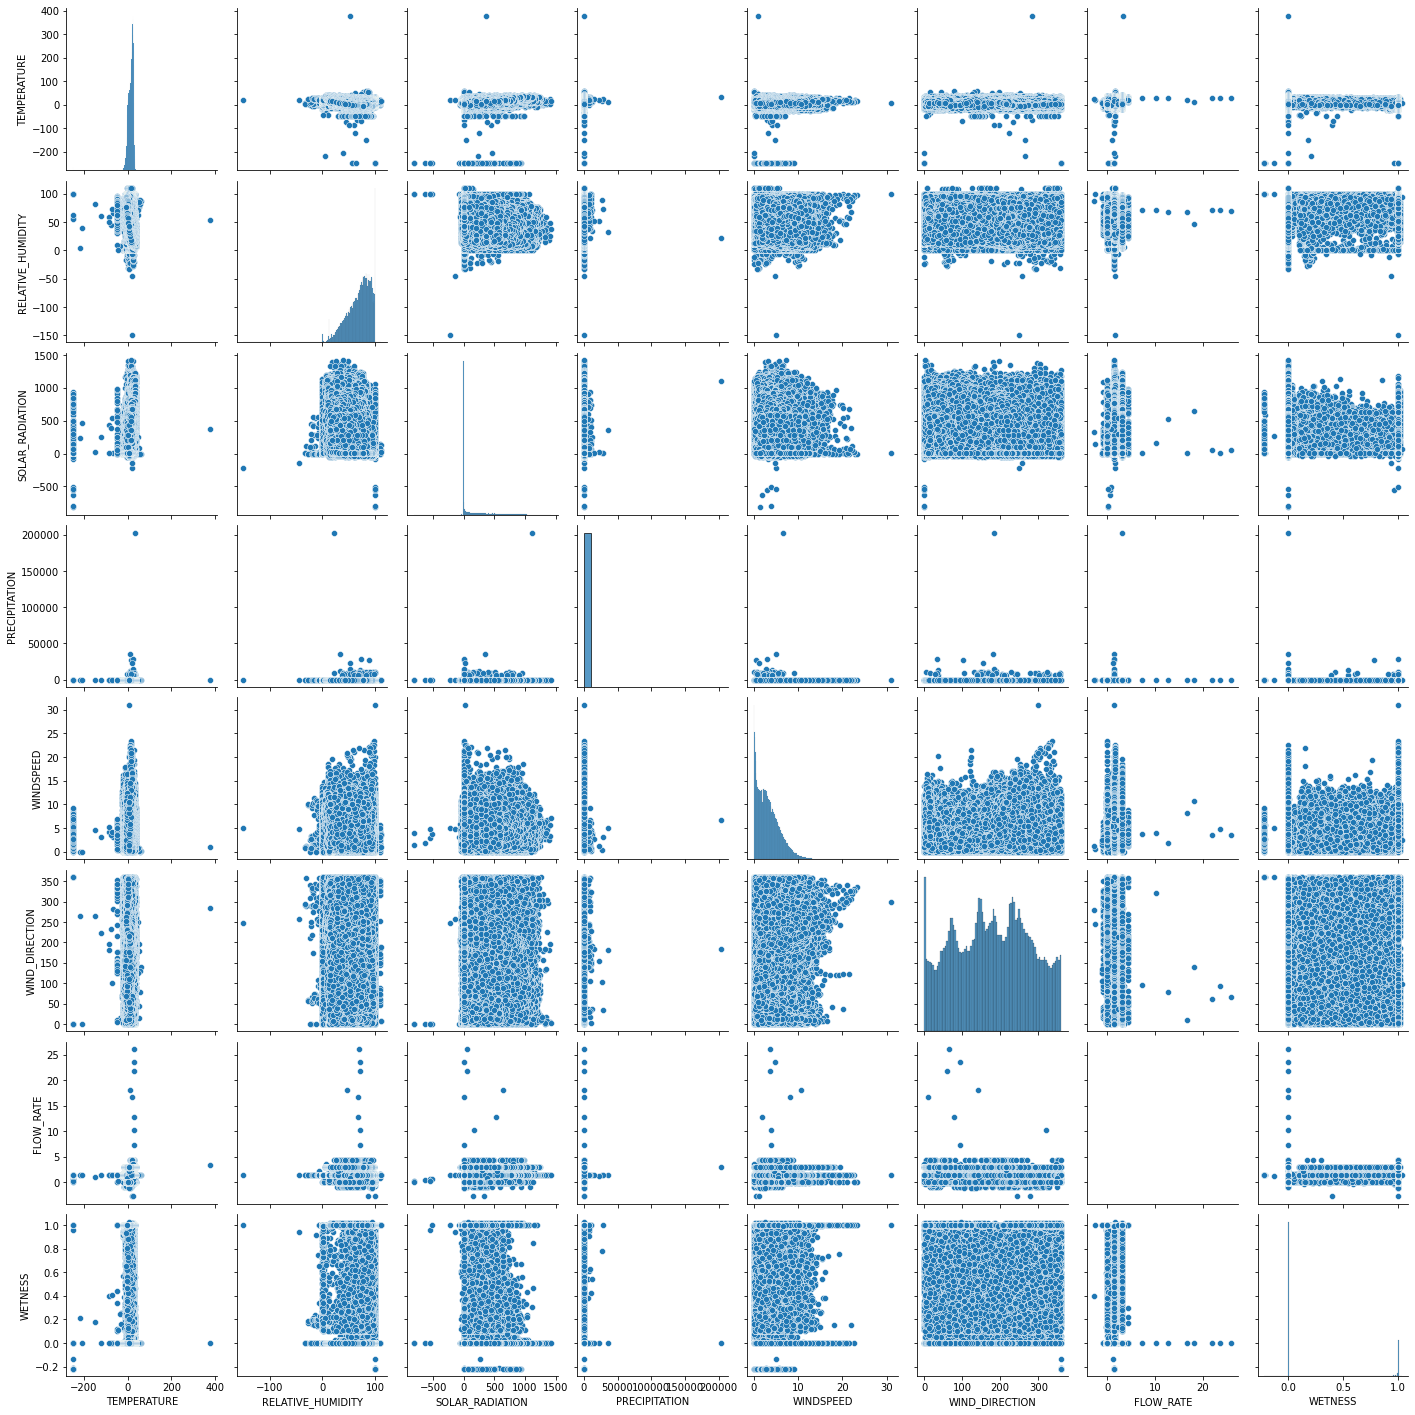

CPU times: user 4min 13s, sys: 19.6 s, total: 4min 32s
Wall time: 4min 45s


In [67]:
%%time
cols = ['TEMPERATURE', 'RELATIVE_HUMIDITY', 'SOLAR_RADIATION',
       'PRECIPITATION', 'WINDSPEED', 'WIND_DIRECTION', 'FLOW_RATE',
       'WETNESS']
sns.pairplot(X[cols])
plt.show()

In [37]:
%%time
correlation_matrix = X.dropna().corr()
correlation_matrix

CPU times: user 107 ms, sys: 19.3 ms, total: 126 ms
Wall time: 125 ms


,TEMPERATURE,TEMPERATURE_DELTA,RELATIVE_HUMIDITY,SOLAR_RADIATION,OZONE,PRECIPITATION,WINDSPEED,WIND_DIRECTION,SIGMA_THETA,FLOW_RATE,...,month,year,Agric,Desert,Forest,Range,Complex,Flat,Mountaintop,Rolling
TEMPERATURE,1.000000,-0.008971,-0.233204,0.364105,0.427338,0.039496,-0.163297,-0.071806,0.286019,-0.046374,...,0.220954,0.122813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TEMPERATURE_DELTA,-0.008971,1.000000,0.047868,0.008736,0.006907,0.001803,0.020083,0.022445,0.012904,-0.001354,...,0.004040,-0.017179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RELATIVE_HUMIDITY,-0.233204,0.047868,1.000000,-0.516111,-0.628749,0.091905,-0.122903,-0.047920,-0.234386,-0.028910,...,0.025479,-0.046381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SOLAR_RADIATION,0.364105,0.008736,-0.516111,1.000000,0.566672,-0.059221,0.087408,0.065577,0.451752,-0.014555,...,-0.033857,0.033762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OZONE,0.427338,0.006907,-0.628749,0.566672,1.000000,0.024076,0.130767,0.023219,0.305665,-0.019049,...,-0.236879,0.001869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PRECIPITATION,0.039496,0.001803,0.091905,-0.059221,0.024076,1.000000,0.009399,-0.011500,0.097816,-0.005464,...,-0.001944,-0.005747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WINDSPEED,-0.163297,0.020083,-0.122903,0.087408,0.130767,0.009399,1.000000,0.163913,-0.328614,-0.015941,...,-0.130557,-0.037914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WIND_DIRECTION,-0.071806,0.022445,-0.047920,0.065577,0.023219,-0.011500,0.163913,1.000000,-0.005356,-0.001874,...,0.040814,-0.009131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SIGMA_THETA,0.286019,0.012904,-0.234386,0.451752,0.305665,0.097816,-0.328614,-0.005356,1.000000,-0.012152,...,0.042125,0.008477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FLOW_RATE,-0.046374,-0.001354,-0.028910,-0.014555,-0.019049,-0.005464,-0.015941,-0.001874,-0.012152,1.000000,...,0.069994,0.023706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
abs(correlation_matrix) > 0.4
# Correlation > 0.5:
# (WINDSPEED_SCALAR, WINDSPEED)
# (WINDSPEED_SCALAR, SIGMA_THETA)
# (WINDSPEED, SIGMA_THETA)
# (RELATIVE_HUMIDITY, SOLAR_RADIATION)
# (RELATIVE_HUMIDITY, OZONE)
# (RELATIVE_HUMIDITY, WETNESS)

,TEMPERATURE,TEMPERATURE_DELTA,RELATIVE_HUMIDITY,SOLAR_RADIATION,OZONE,PRECIPITATION,WINDSPEED,WIND_DIRECTION,SIGMA_THETA,FLOW_RATE,...,month,year,Agric,Desert,Forest,Range,Complex,Flat,Mountaintop,Rolling
TEMPERATURE,True,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
TEMPERATURE_DELTA,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
RELATIVE_HUMIDITY,False,False,True,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
SOLAR_RADIATION,False,False,True,True,True,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
OZONE,True,False,True,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
PRECIPITATION,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
WINDSPEED,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
WIND_DIRECTION,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
SIGMA_THETA,False,False,False,True,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
FLOW_RATE,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [12]:
df[features_and_label]

,TEMPERATURE,TEMPERATURE_DELTA,RELATIVE_HUMIDITY,SOLAR_RADIATION,PRECIPITATION,WINDSPEED,WETNESS,SHELTER_TEMPERATURE,CO,FLOW_23M,...,NH3,NO,NOX,NOY,LATITUDE,LONGITUDE,ELEVATION,LAND_USE,TERRAIN,OZONE
0,3.8590,0.0440,67.7900,0.4750,0.0000,1.0080,0.0000,27.0500,None,None,...,None,0.0290,None,None,39.028177,-76.817127,47.00000,Range,Flat,23.3200
1,1.5730,0.0570,63.0100,0.4710,0.0000,0.7250,0.0000,26.5600,None,None,...,None,0.0250,None,None,39.028177,-76.817127,47.00000,Range,Flat,30.5300
2,-0.3470,0.1750,64.3200,9.4500,0.0000,0.6740,0.0000,25.6900,None,None,...,None,0.0310,None,None,39.028177,-76.817127,47.00000,Range,Flat,28.3700
3,-0.4400,0.0530,64.2200,106.4000,0.0000,0.8180,0.0000,25.3400,None,None,...,None,0.7330,None,None,39.028177,-76.817127,47.00000,Range,Flat,26.0000
4,1.4860,-0.1930,44.6300,182.8000,0.0000,1.1140,0.0000,26.6900,None,None,...,None,0.7130,None,None,39.028177,-76.817127,47.00000,Range,Flat,33.6900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574846,-4.1350,None,None,None,None,None,None,24.8800,None,None,...,None,0.0320,None,0.1260,40.278129,-105.545635,2742.00000,Forest,Complex,47.0300
574847,-0.6020,None,None,None,None,None,None,27.3400,None,None,...,None,0.1470,None,0.2490,40.278129,-105.545635,2742.00000,Forest,Complex,45.1300
574848,-8.8900,None,None,None,None,None,None,24.9700,None,None,...,None,0.0220,None,0.6840,40.278129,-105.545635,2742.00000,Forest,Complex,40.6300
574849,-2.6780,None,None,None,None,None,None,24.6900,None,None,...,None,0.0310,None,0.1110,40.278129,-105.545635,2742.00000,Forest,Complex,46.4600


In [22]:
features_and_label = ['TEMPERATURE', 'TEMPERATURE_DELTA', 'RELATIVE_HUMIDITY', 'SOLAR_RADIATION',
                     'PRECIPITATION', 'WINDSPEED', 'WETNESS', 'SHELTER_TEMPERATURE', 'CO',
                      'HNO3', 'NH3', 'NO', 'NOX', 'NOY', 'LATITUDE', 'LONGITUDE',
                      'ELEVATION', 'OZONE']
df_features = df[features_and_label].astype(float)

In [21]:
df[['FLOW_2M', 'FLOW_23M']].dropna()

,FLOW_2M,FLOW_23M


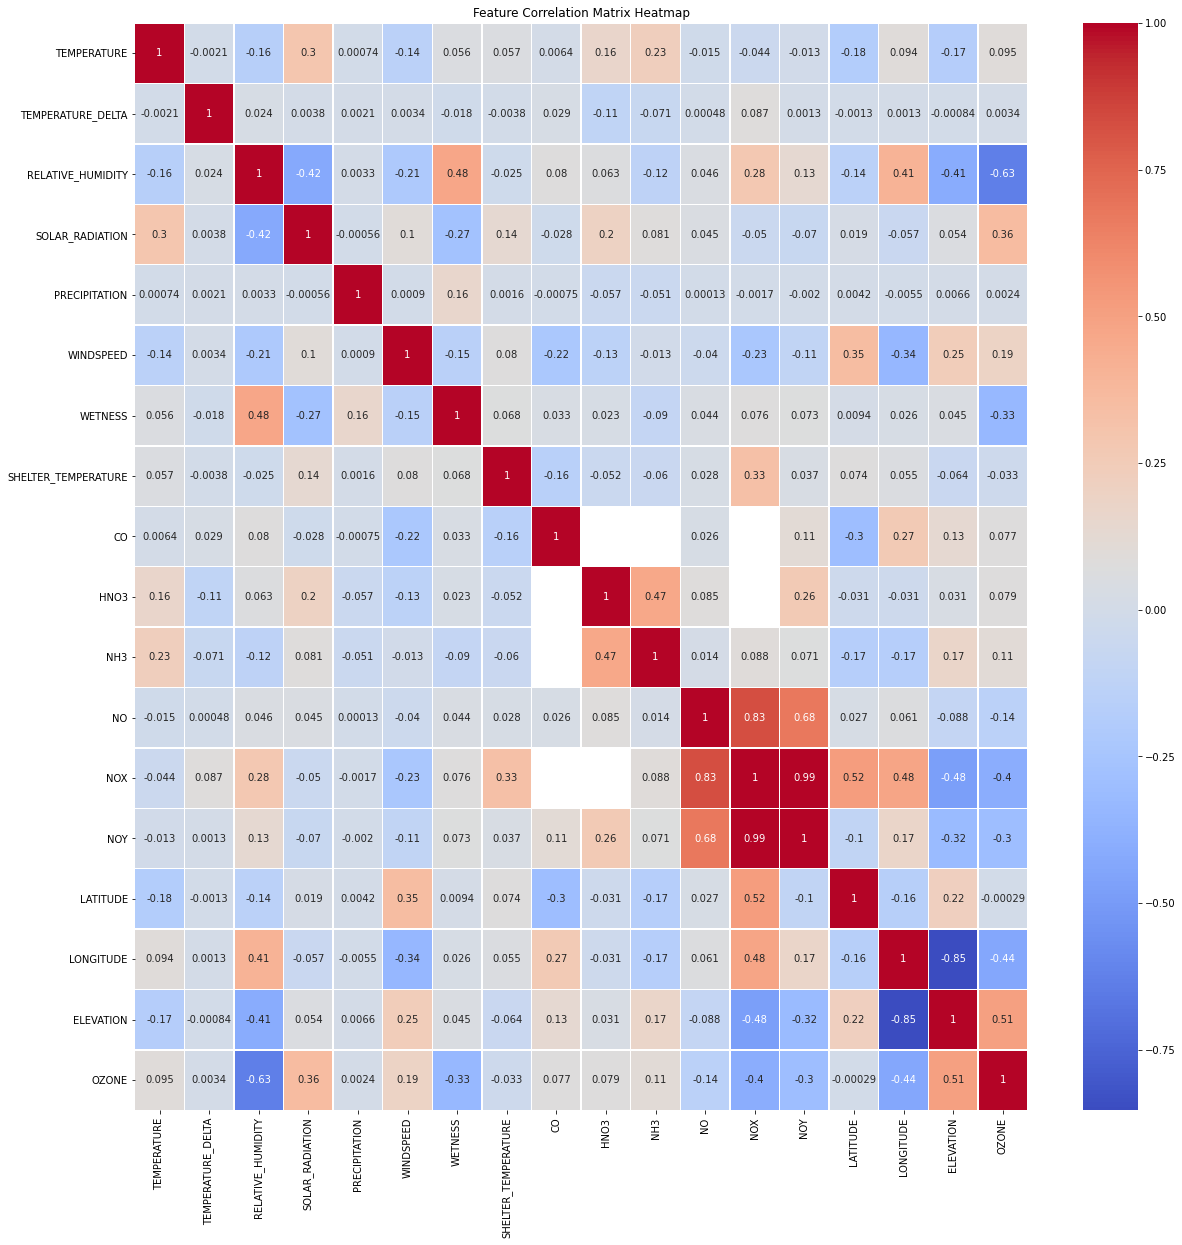

In [23]:
correlation_matrix = df[features_and_label].corr()

plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix Heatmap')
plt.show()

In [28]:
all_features = df.columns.tolist()
all_features

['SITE_ID',
 'DATE_TIME',
 'TEMPERATURE',
 'TEMPERATURE_F',
 'TEMPERATURE_DELTA',
 'TEMPERATURE_DELTA_F',
 'RELATIVE_HUMIDITY',
 'RELATIVE_HUMIDITY_F',
 'SOLAR_RADIATION',
 'SOLAR_RADIATION_F',
 'OZONE',
 'OZONE_F',
 'PRECIPITATION',
 'PRECIPITATION_F',
 'WINDSPEED',
 'WINDSPEED_F',
 'WIND_DIRECTION',
 'WIND_DIRECTION_F',
 'SIGMA_THETA',
 'SIGMA_THETA_F',
 'FLOW_RATE',
 'FLOW_RATE_F',
 'WINDSPEED_SCALAR',
 'WINDSPEED_SCALAR_F',
 'WETNESS',
 'WETNESS_F',
 'SHELTER_TEMPERATURE',
 'SHELTER_TEMPERATURE_F',
 'QA_CODE',
 'UPDATE_DATE',
 'Filename',
 'CO',
 'FLOW_23M',
 'FLOW_2M',
 'HNO3',
 'NH3',
 'NO',
 'NO2_TRUE',
 'NOX',
 'NOXDIF',
 'NOX_TRUE',
 'NOY',
 'NOYDIF',
 'NOY_MINUS',
 'SO2_GA',
 'TNX',
 'LATITUDE',
 'LONGITUDE',
 'ELEVATION',
 'LAND_USE',
 'TERRAIN']

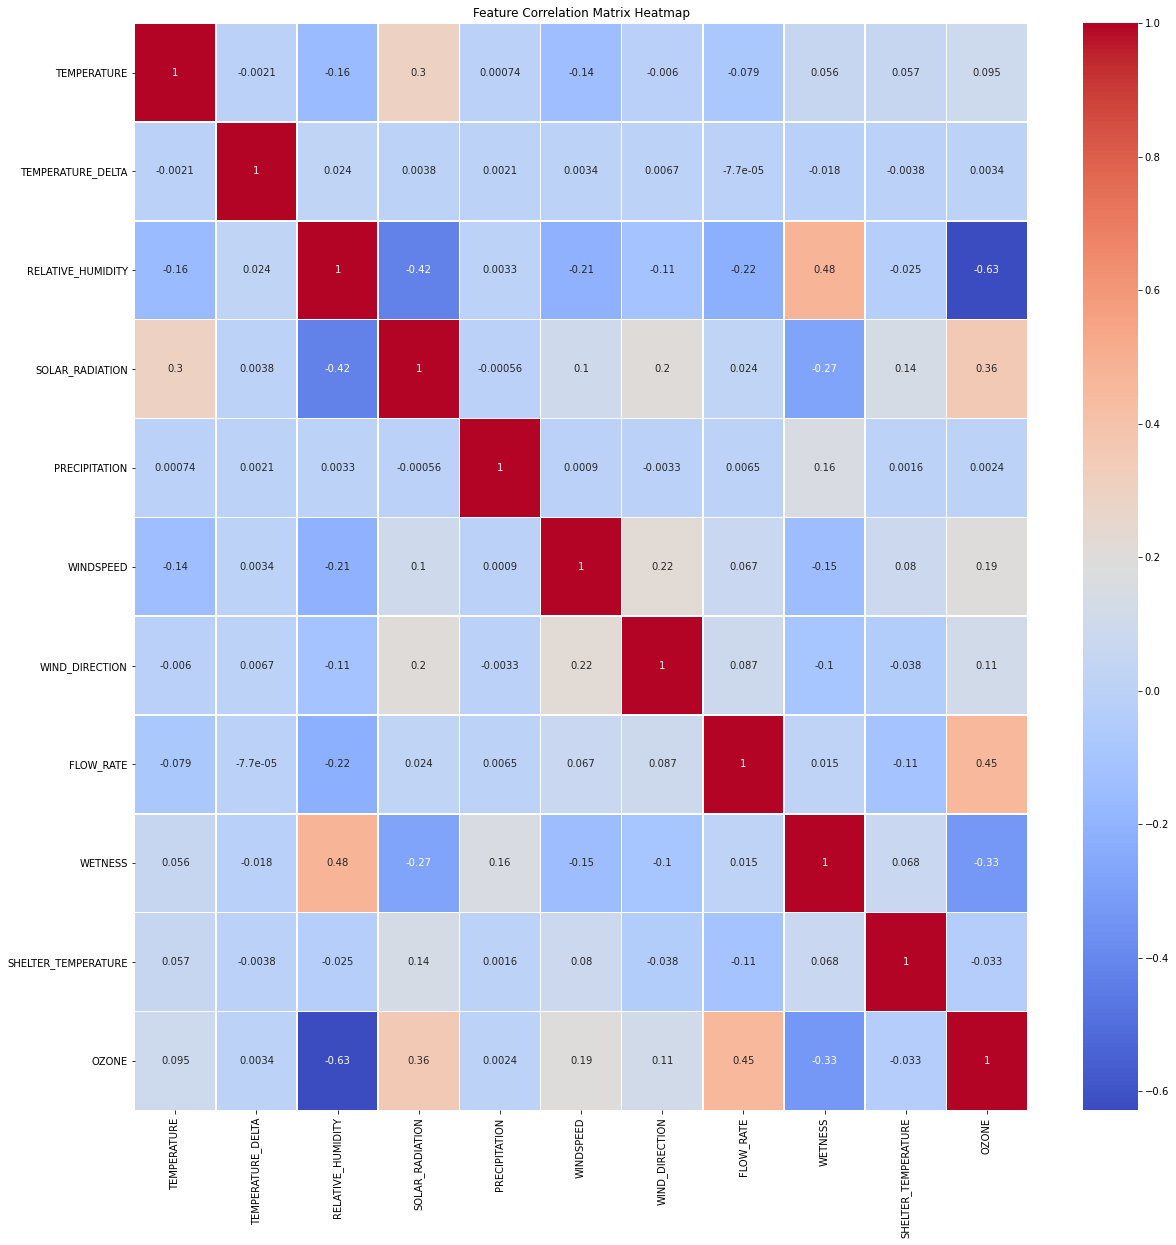

In [41]:
gas_features_and_label = ['TEMPERATURE', 'TEMPERATURE_DELTA', 'RELATIVE_HUMIDITY',
                          'SOLAR_RADIATION', 'PRECIPITATION', 'WINDSPEED', 'WIND_DIRECTION',
                          'FLOW_RATE', 'WETNESS', 'SHELTER_TEMPERATURE','OZONE']
df_gas_features = df[gas_features_and_label].astype(float)

correlation_matrix = df_gas_features.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix Heatmap')
plt.savefig('gas_correlation_matrix.png', dpi=300)
plt.show()

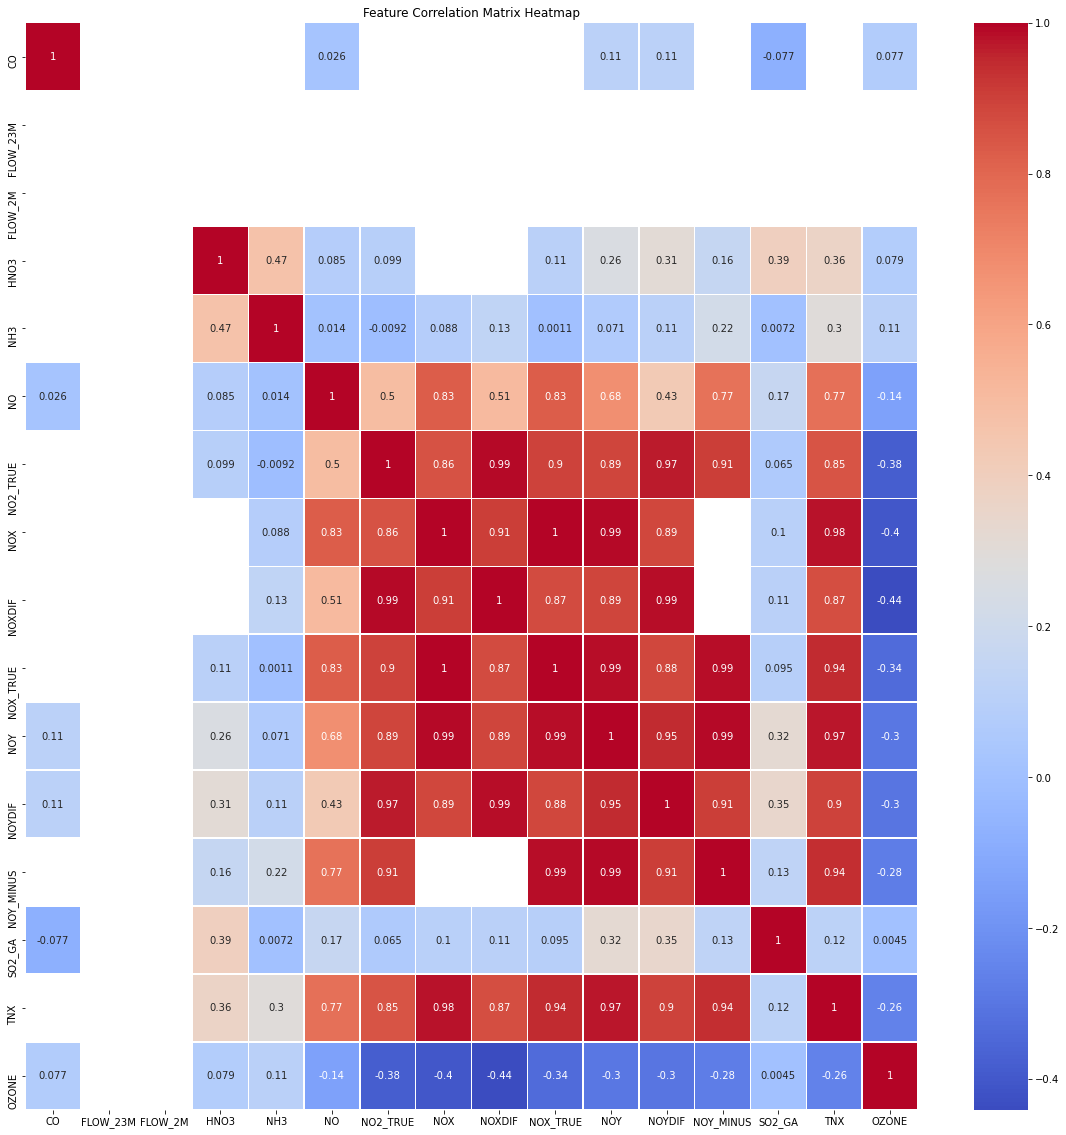

In [42]:
chemical_features_and_label = all_features[31:46] + ['OZONE']
chemical_features_and_label
df_chemical_features = df[chemical_features_and_label].astype(float)

correlation_matrix = df_chemical_features.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix Heatmap')
plt.savefig('chemical_correlation_matrix.png', dpi=300)
plt.show()

In [27]:
df['NOX'].value_counts(dropna=False)

NOX
None      525205
0.4000      3678
0.3000      3596
0.5000      3481
0.6000      3047
           ...  
7.2140         1
7.3240         1
3.1990         1
4.4270         1
3.3170         1
Name: count, Length: 6506, dtype: int64

## Initial Modeling

**Split data**

In [62]:
df['DATE_TIME']
df['month'] = df['DATE_TIME'].dt.month
df['year'] = df['DATE_TIME'].dt.year

In [64]:
df['year'].value_counts()

year
2020    68635
2019    66944
2021    64958
2016    60811
2015    60228
2022    58416
2018    56521
2017    56215
2014    45988
2013    36135
Name: count, dtype: int64

In [80]:
# drop all non-numerical features
X = df.drop(columns=flag_columns)
X = X.drop(columns=['SITE_ID', 'UPDATE_DATE', 'DATE_TIME', 'Filename'])
X.dtypes

TEMPERATURE            float64
TEMPERATURE_DELTA      float64
RELATIVE_HUMIDITY      float64
SOLAR_RADIATION        float64
OZONE                  float64
PRECIPITATION          float64
WINDSPEED              float64
WIND_DIRECTION         float64
SIGMA_THETA            float64
FLOW_RATE              float64
WINDSPEED_SCALAR       float64
WETNESS                float64
SHELTER_TEMPERATURE    float64
CO                     float64
HNO3                   float64
NH3                    float64
NO                     float64
NO2_TRUE               float64
NOX                    float64
NOXDIF                 float64
NOX_TRUE               float64
NOY                    float64
NOYDIF                 float64
NOY_MINUS              float64
SO2_GA                 float64
TNX                    float64
LATITUDE               float64
LONGITUDE              float64
ELEVATION              float64
month                    int32
year                     int32
Agric                  float64
Desert  

In [83]:
# Training data is from 2013-2018
# Valid data is from 2019-2020
# Test data is from 2021-2022

df_2013_2018 = X[X['year'].isin([2013, 2014, 2015, 2016, 2017, 2018])]
X_train, y_train = df_2013_2018.drop(columns=['OZONE'], axis=1), df_2013_2018['OZONE']

df_2019_2020 = X[X['year'].isin([2019, 2020])]
X_val, y_val = df_2019_2020.drop(columns=['OZONE'], axis=1), df_2019_2020['OZONE']

df_2021_2022 = X[X['year'].isin([2021, 2022])]
X_test, y_test = df_2021_2022.drop(columns=['OZONE'], axis=1), df_2021_2022['OZONE']

print(len(X_train) / len(df))
print(len(X_val) / len(df))
print(len(X_test) / len(df))

0.5495302260933703
0.23585068130698217
0.21461909259964757


In [126]:
X.dropna()

,TEMPERATURE,TEMPERATURE_DELTA,RELATIVE_HUMIDITY,SOLAR_RADIATION,OZONE,PRECIPITATION,WINDSPEED,WIND_DIRECTION,SIGMA_THETA,FLOW_RATE,...,month,year,Agric,Desert,Forest,Range,Complex,Flat,Mountaintop,Rolling


### Drop NA

In [93]:
X.isna().sum() / len(X)

TEMPERATURE            0.000478
TEMPERATURE_DELTA      0.804843
RELATIVE_HUMIDITY      0.381334
SOLAR_RADIATION        0.391444
OZONE                  0.000000
PRECIPITATION          0.390978
WINDSPEED              0.379180
WIND_DIRECTION         0.379300
SIGMA_THETA            0.379180
FLOW_RATE              0.065090
WINDSPEED_SCALAR       0.379187
WETNESS                0.800357
SHELTER_TEMPERATURE    0.000929
CO                     0.706778
HNO3                   0.960452
NH3                    0.952638
NO                     0.034746
NO2_TRUE               0.940498
NOX                    0.913637
NOXDIF                 0.910121
NOX_TRUE               0.940341
NOY                    0.114318
NOYDIF                 0.122244
NOY_MINUS              0.957940
SO2_GA                 0.604252
TNX                    0.948917
LATITUDE               0.000000
LONGITUDE              0.000000
ELEVATION              0.000000
month                  0.000000
year                   0.000000
Agric   

In [98]:
X_less_sparse = X.drop(columns=['HNO3', 'NH3', 'NO2_TRUE', 'NOX', 'NOXDIF', 'NOX_TRUE',
                               'NOY_MINUS', 'SO2_GA', 'TNX'])
X_less_sparse.dropna(inplace=True)

# Training data is from 2013-2018
# Valid data is from 2019-2020
# Test data is from 2021-2022

df_2013_2018 = X_less_sparse[X_less_sparse['year'].isin([2013, 2014, 2015, 2016, 2017, 2018])]
X_train, y_train = df_2013_2018.drop(columns=['OZONE'], axis=1), df_2013_2018['OZONE']

df_2019_2020 = X_less_sparse[X_less_sparse['year'].isin([2019, 2020])]
X_val, y_val = df_2019_2020.drop(columns=['OZONE'], axis=1), df_2019_2020['OZONE']

df_2021_2022 = X_less_sparse[X_less_sparse['year'].isin([2021, 2022])]
X_test, y_test = df_2021_2022.drop(columns=['OZONE'], axis=1), df_2021_2022['OZONE']

print(len(X_train) / len(X_less_sparse))
print(len(X_val) / len(X_less_sparse))
print(len(X_test) / len(X_less_sparse))

0.7496340347666972
0.10818847209515096
0.14217749313815187


**Scale data**

In [127]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

### Linear Regression

In [100]:
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, accuracy_score

model = LinearRegression()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
print(r2_score(y_train, y_pred_train))

y_pred_val = model.predict(X_val)
print(r2_score(y_val, y_pred_val))

# These scores are from the less sparse matrix

0.6603475819064889
0.3091458803503708


### Ridge Regression

In [124]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

model_ridge = Ridge()
model_ridge.fit(X_train, y_train)

y_pred_train = model_ridge.predict(X_train)
print(r2_score(y_train, y_pred_train))

y_pred_val = model_ridge.predict(X_val)
print(r2_score(y_val, y_pred_val))


0.6603310830107756
0.3091838351309186


### Lasso Regression

In [123]:
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

model_lasso = Lasso()
model_lasso.fit(X_train, y_train)

y_pred_train = model_lasso.predict(X_train)
print(r2_score(y_train, y_pred_train))

y_pred_val = model_lasso.predict(X_val)
print(r2_score(y_val, y_pred_val))


0.6509012909894926
0.5830776416680028


### Random Forest

In [125]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

model_rf = RandomForestRegressor(random_state=123)
model_rf.fit(X_train, y_train)


y_pred_train = model_rf.predict(X_train)
print(r2_score(y_train, y_pred_train))

y_pred_val = model_rf.predict(X_val)
print(r2_score(y_val, y_pred_val))


0.9863176527967061
0.7292131898448704


### KNN

In [113]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

for k in [1,3,5,8,10,12,15,20,25,50,100]:
    model_knn = KNeighborsRegressor(n_neighbors = k)
    model_knn.fit(X_train, y_train)
    y_pred_val = model_knn.predict(X_val)
    print("k = " + str(k))
    print(r2_score(y_val, y_pred_val))

k = 1
-0.16822933172054366
k = 3
0.2431658507834059
k = 5
0.33398042480375456
k = 8
0.39434285356324406
k = 10
0.4149328100240738
k = 12
0.42684498720037967
k = 15
0.436201264194663
k = 20
0.4437347625235647
k = 25
0.44527665992638343
k = 50
0.44124538535427904
k = 100
0.42947445633370473


### Gradient Boost

In [114]:
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb


model_gb = GradientBoostingRegressor(random_state=123)
model_gb.fit(X_train, y_train)
y_pred_val = model_gb.predict(X_val)

print("R2:")
print(r2_score(y_val, y_pred_val))

R2:
0.725934142069285


### XGBoost

In [ ]:
#!pip install xgboost

In [119]:
model_xgb = xgb.XGBRegressor(random_state=321)
model_xgb.fit(X_train, y_train)
y_pred_val = model_xgb.predict(X_val)

print("R2 score:")
print(r2_score(y_val, y_pred_val))

R2 score:
0.6532484844821063


In [120]:
%%time

import xgboost as xgb

param_grid = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [5, 10, 20, 30]
}

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(random_state=321),
    param_grid=param_grid,
    cv=5,
    scoring='r2')

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

model_xgb_best = xgb.XGBRegressor(**best_params, random_state=321)
model_xgb_best.fit(X_train, y_train)
y_pred_val = model_xgb_best.predict(X_val)
print("Optimal parameters:")
print("learning_rate: " + str(best_params['learning_rate']))
print("n_estimators: " + str(best_params['n_estimators']))
print("max_depth: " + str(best_params['max_depth']))
print("R2 score:")
print(r2_score(y_val, y_pred_val))

KeyboardInterrupt: 